In [1]:
import torch
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns

sns.set()
torch.set_printoptions(sci_mode = False)

In [2]:
def ReweightFeatures(features, weight):
    
    '''
    Reweights features accroading to weight.
    features: [N_batches (Nb), dim]
    weight:   [dim,]
    '''
    
    # Apply weight sign and sort features and abs weights
    features_signed = features * (torch.sign(weights))
    features_sorted, features_order = torch.sort(features_signed)
    weights_sorted = torch.abs(weights)[features_order] # => [Nb, dim]
    
    # Collect prefix-sum of weight vectors, with an appended zero in front
    weights_cumsum = torch.cumsum(torch.abs(weights_sorted), dim = 1)
    weights_cumsum = torch.cat(
        [
            torch.zeros((weights_cumsum.shape[0], 1), device = weights_cumsum.device), 
            weights_cumsum
        ],
        dim = 1
    )
    
    # Create uniform-sampled points for reweighting
    weights_total = weights_cumsum[:, -1]
    uniformed = torch.linspace(start = 0, end = weights_total[0], device = weights.device, steps = weights.shape[0])#.unsqueeze(0) * weights_total.unsqueeze(1)
    uniformed = uniformed.unsqueeze(0).repeat(weights_cumsum.shape[0], 1)

    # Perform binary search to find interpolation ends
    searched_results = torch.searchsorted(weights_cumsum, uniformed)
    searched_results[:, 0] = 1 # Remove first 0's 
    
    # Linear interpolation: starts[ <------------ interp --> ] ends
    starts = torch.gather(features_sorted, -1, searched_results - 1)
    ends = torch.gather(features_sorted, -1, torch.minimum(searched_results, torch.ones((1,), dtype = torch.long, device = features_sorted.device) * (features_sorted.shape[-1] - 1)))

    # Linear interpolation: obtain interp from both weight ends
    weights_s = torch.gather(weights_cumsum, -1, searched_results - 1)
    weights_e = torch.gather(weights_cumsum, -1, searched_results)
    interp = (uniformed - weights_s) / (weights_e - weights_s)
    
    # Do the interpolation
    result = starts + (ends - starts) * interp
    return result

In [3]:
features = torch.normal(mean = torch.zeros(2, 1024)).cuda()
# weights = torch.normal(mean = torch.zeros(1024,))
weights = torch.linspace(-1, 10, steps = 1024).cuda()

weights[0] = 1000

<AxesSubplot:ylabel='Count'>

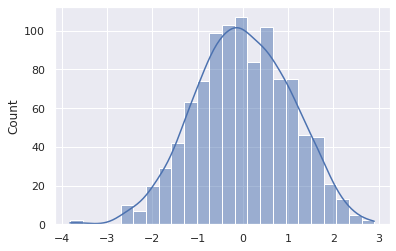

In [4]:
sns.histplot(features[0].cpu().numpy(), kde = True)

In [5]:
rf = ReweightFeatures(features, weights)

<AxesSubplot:ylabel='Count'>

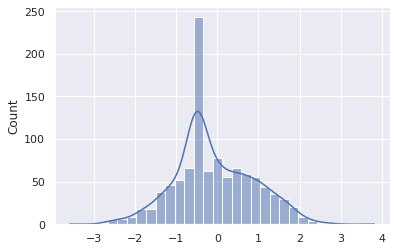

In [6]:
sns.histplot(rf[0].cpu().numpy(), kde = True)

In [7]:
# features_signed = features * (torch.sign(weights))
# features_sorted, features_order = torch.sort(features_signed)

# print(features_sorted)
# print(features_order)

# weights_sorted = torch.abs(weights)[features_order]

# print(weights_sorted)

In [8]:
# weights_cumsum = torch.cumsum(torch.abs(weights_sorted), dim = 1)
# weights_cumsum = torch.cat(
#     [
#         torch.zeros((weights_cumsum.shape[0], 1), device = weights_cumsum.device), 
#         weights_cumsum
#     ],
#     dim = 1
# )
# print(weights_cumsum)

In [9]:
# weights_total = weights_cumsum[:, -1]
# uniformed = torch.linspace(start = 0, end = weights_total[0], steps = weights.shape[0])#.unsqueeze(0) * weights_total.unsqueeze(1)
# uniformed = uniformed.unsqueeze(0).repeat(weights_cumsum.shape[0], 1)
# print(uniformed)

In [10]:
# plt.figure(figsize = (14, 8))
# for i in range(len(features_sorted)):
#     sns.lineplot(x = features_sorted[i], y = uniformed[i])
# plt.show()

In [11]:
# searched_results = torch.searchsorted(weights_cumsum, uniformed)
# # Remove first 0's
# searched_results[:, 0] = 1
# print(searched_results)

In [12]:
# # Linear interpolation
# starts = torch.gather(features_sorted, -1, searched_results - 1)
# ends = torch.gather(features_sorted, -1, torch.minimum(searched_results, torch.LongTensor([features_sorted.shape[-1] - 1], device = features_sorted.device)))

# weights_s = torch.gather(weights_cumsum, -1, searched_results - 1)
# weights_e = torch.gather(weights_cumsum, -1, searched_results)
# interp = (uniformed - weights_s) / (weights_e - weights_s)

# print(starts)
# print(ends)
# print(interp)

In [13]:
# # Linear interpolation; cont'd
# result = starts + (ends - starts) * interp
# print(result)

# plt.figure(figsize = (14, 8))
# for i in range(len(result)):
#     sns.lineplot(x = result[i], y = uniformed[i])
# plt.show()